In [71]:
import numpy as np

import matplotlib.pyplot as plt

microm2m = 1.0E-6
m2microm = 1.0E6

In [72]:
import numpy as np
import math

from numpy import linspace, zeros, array, pi, sin, cos, exp, arange
from scipy.fftpack import fft, ifft, dct, idct, dst, idst, fftshift, fftfreq

from math import sqrt
from skimage import data
from skimage.feature import blob_log


import matplotlib.pyplot as plt

from apsg import *





def cartesian_components(D, I, Q, R):
    
    """
    Calculates the cartesian components of  natural remanent magnetization (NRM)
    for uniformily magnetized spheres (mx, my, mz) required in the forward model.

    Parameters:
        * D: 1D-array containing magnetization declination (0 to 360 degrees)
        * I: 1D-array containing magnetization inclination (-90 to 90  degress)
        * Q: 1D-array containing magnetization intensity (A/m)
        * R: 1D-array containing sphere's radius (m)

    Constant:
        * cm: is a constant given by 4*np.pi/µo = 10**(-7) 
            where µo is the vaccum magnetic permeability
    """
    
    
    cm = 10**(-7) # H/m  == T·m/A
    m = []

    for i in range(np.size(D)):
        m_sphere =  np.matrix([[(Q[i]*np.cos(I[i]*(np.pi/180))*np.cos(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                          [(Q[i]*np.cos(I[i]*(np.pi/180))*np.sin(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                           [(Q[i]*np.sin(I[i]*(np.pi/180)))*((cm*4.0*np.pi*R[i]**3)/3.0)                            ]])

        m = np.append(m,m_sphere)
        
    return(np.array(m))



def sensibility_matrix(X, Y, Z, Xc, Yc, Zc): 
    
    """
    Generates the sensibility matrix for vertical component of magnetization

    Parameters:
        *  X,  Y,  Z: 1D-arrays with x, y and z data positions
        * Xc, Yc, Zc: 1D-arrays with x, y and z data  of the sphere's center positions
    """

    dzz = np.zeros(np.shape(Z))
    dxz = np.zeros(np.shape(Z))
    dzy = np.zeros(np.shape(Z))


    for j in range(len(Xc)):
        for i in range(len(X)):
            dzz[i] =  -1.0*( (X[i]-Xc[j])**2+(Y[i]-Yc[j])**2-2*(Z[i]-Zc[j])**2) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dxz[i] = ( 3.0*(X[i]-Xc[j])*(Z[i]-Zc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dzy[i] = ( 3.0*(Z[i]-Zc[j])*(Y[i]-Yc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            
        M = ([[dxz],[dzy],[dzz]])
        
        M = np.reshape(M, (3, np.size(dzz)))
        M.T
        
        if j==0:
            Mz = np.copy(M)
        else:
            Mz = np.concatenate((Mz,M), axis=0)


    return(Mz.T) # sensibility matrix                    
    


def regular(area, shape, z=None):
    
    """
    Generates the regular grid --> source https://legacy.fatiando.org/cookbook.html

    Parameters:
        * area: array with x axis size (nx) and y axis size (ny)
        * shape: array with min(x), max(x), min(y) and max(y)
        * z: float with the distance between the sample surface and the sensor
    """
    
    nx, ny = shape
    x1, x2, y1, y2 = area
    xs = np.linspace(x1, x2, nx)
    ys = np.linspace(y1, y2, ny)
    
    arrays = np.meshgrid(ys, xs)[::-1]
    
    if z is not None:
        arrays.append(z*np.ones(nx*ny, dtype=np.float64))
    return [i.ravel() for i in arrays]



def noise(d, error=0.05):
    
    """
    Generates a Gaussian noise (normal distribution, mean equals zero, and desv. pad. equals the error percent input)

    Parameters:
        * d: simulated data vector
        * percent_erro: error percentage (default = 5%) based on the maximum amplitude of the anomaly 

    """
    
    sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
    delta_d = np.array(np.random.normal(0,sigma_noise,len(d)))
    delta_D = np.transpose(delta_d)

    d_noise = d+delta_D
 
    return (d_noise)





def y_derivative_fft(d_, Y_): 
    
    ddy = np.zeros(np.shape(d_))
    ky = np.zeros(np.shape(d_))

    # y derivative
    for i in range(np.shape(d_)[0]):
        Ny = np.size(d_[i,:])
        y = Y_[i,:]
        dy = y[1]-y[0]

        fy = d_[i,:]
        k = fftfreq(Ny,dy)

        derivative_y   = np.real(ifft(2*pi*k*1j*fft(fy)))

        ddy[i,:] = derivative_y
        ky[i,:] = k
    
    return(ddy, ky)




def x_derivative_fft(d_, X_):
    ddx = np.zeros(np.shape(d_))
    kx = np.zeros(np.shape(d_))
    
    # x derivative 
    for j in range(np.shape(d_)[1]):
        Nx = np.size(d_[:,j])
        x = np.transpose(X_[:,j])
        dx = x[1]-x[0]

        fx = np.transpose(d_[:,j])
        k = fftfreq(Nx,dx)

        derivative_x   = np.real(ifft(2*pi*k*1j*fft(fx)))

        ddx[:,j] = derivative_x
        kx[:,j] = k
        
    return(ddx, kx)




def z_derivative_fft(d, kx, ky):
    
    # derivative Z
    kx_ = np.reshape(kx,   (1,int(np.size(kx))))
    ky_ = np.reshape(ky.T, (1,int(np.size(ky))))
    
    kz = np.absolute(np.sqrt(kx_**2+ky_**2))
    kz_ = np.reshape(kz, (1,int(np.size(kz))))
    
    kz = np.absolute(np.sqrt(kx_**2+ky_**2))
    kz_ = np.reshape(kz, (1,int(np.size(kz))))

    #ddz = np.zeros(np.shape(d))
    fz = np.reshape(d, (1,int(np.size(d)))) #np.transpose(d)
    #fz = d
    derivative_z = np.real(ifft((np.absolute(2*pi*kz_))*fft(fz)))

    ddz = derivative_z
    ddz = np.reshape(ddz, np.shape(kx))
    
    return(ddz)




def derivative_fd(vertical_field,X,Y):
    derivative_X=np.zeros(np.shape(vertical_field))
    derivative_Y=np.zeros(np.shape(vertical_field))
    
    for j in range(np.shape(X)[1]-1):
        for i in range(np.shape(Y)[0]-1):
            derivative_X[i,j]=np.array((vertical_field[i+1,j]-vertical_field[i-1,j])/(X[i+1,j]-X[i-1,j]))
            derivative_Y[i,j]=np.array((vertical_field[i, j+1]-vertical_field[i,j-1])/(Y[i,j+1]-Y[i,j-1]))
    derivative_X[0,:] = derivative_X[1,:]
    derivative_X[-1,:] = derivative_X[-2,:]
    derivative_Y[:,0] = derivative_Y[:,1]
    derivative_Y[:,-1] = derivative_Y[:,-2]
    
    
    return(derivative_X, derivative_Y)



def Horiz_Grad(DX, DY): 
    
    HG = np.sqrt(np.absolute(DY**2+DX**2))
    
    return(HG)


def upward_continuation(d_, delta_z, kx, ky):
                     
    
    kx_ = np.reshape(kx, (1,int(np.size(kx))))
    ky_ = np.reshape(ky.T,(1,int(np.size(ky))))
    
    kz = np.absolute(np.sqrt(kx_**2+ky_**2))
    kz_ = np.reshape(kz, (1,int(np.size(kz))))
    
    
    f = (np.reshape(d_, (1,int(np.size(d_)))))
    #f = d_
    fhat = fft(f)
    
    up_cont_factor = np.exp((delta_z)*(2*pi*kz_))
    
    up_cont = np.real(ifft(fhat*up_cont_factor))   
    up_cont = np.reshape(up_cont, np.shape(kx))
    
    print(np.shape(up_cont))
    
    up_cont[0,:] = up_cont[1,:]
    up_cont[-1,:] = up_cont[-2,:]
    up_cont[:,0] = up_cont[:,1]
    up_cont[:,-1] = up_cont[:,-2]
    
    return(up_cont)


def z_derivative_fd(upward_1, upward_2, delta_Z1, delta_Z2):
    derivative_Z = np.zeros(np.shape(upward_1))
        
    for i in range(np.shape(upward_1)[0]-1):
        for j in range(np.shape(upward_1)[1]-1):
            derivative_Z[i,j]=np.array((upward_1[i,j]-upward_2[i,j])/(np.absolute(delta_Z2 - delta_Z1)))
    
    return(derivative_Z)



def sources_finder(Horiz_Grad, threshold=.05, data = []):
    
    input_data = (Horiz_Grad / Horiz_Grad.max())  # normalizando o dado entrada (0<= dado <=1)
    
#     mean = np.mean(input_data)
#     for j in range(np.shape(input_data)[1]):
#         for i in range(np.shape(input_data)[0]):
#             if (input_data[i,j] <= 20) & (input_data[i,j] >= 10):
#                 input_data[i,j] = 255
#             else:
#                 input_data[i,j] = 0

#     input_data = (input_data / input_data.max())
    
    blobs_log = blob_log(input_data, min_sigma=2, max_sigma=100, num_sigma=100, threshold = threshold, overlap=0.0)


    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Localização de Fontes (Laplacian of Gaussian)']
    sequence = zip(blobs_list, colors, titles)

    circles = []

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(1, 1, 1)
    for idx, (blobs, color, title) in enumerate(sequence):
        plt.title(title, fontsize=18)
        
        if np.size(data)==0:
            plt.imshow(input_data)
        else:
            plt.imshow(data)
        plt.gca().invert_yaxis()
        for blob in blobs:
            y, x, r = blob
            if r>=3: # descarta qualquer blob menor que a resolução mínima do modelo
                circles = np.append(circles, [np.round(y),np.round(x),np.round(r+0.5*r)])
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax.add_patch(c)
                #ax.set_xlim(0, shape[0]-1)
                #ax.set_ylim(0, shape[1]-1)


    plt.tight_layout()
    plt.show()
    
    return(np.array(circles))




def solve_euler(X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index, delta_z):
    


    # first member --> components of A matrix
    d_X_ = np.array(np.reshape(ddx, (np.size(ddx),1)))
    d_Y_ = np.array(np.reshape(ddy, (np.size(ddy),1)))
    d_Z_ = np.array(np.reshape(ddz, (np.size(ddz),1)))
    ni   = np.array(np.ones(np.shape(d_X_))*structural_index)

    A = np.zeros((np.size(d_X_), 4))
    A[:,0] = d_X_[:,0]
    A[:,1] = d_Y_[:,0]
    A[:,2] = d_Z_[:,0]
    A[:,3] = ni[:,0]

    # second member --> vector B
    X_1  = np.array(np.reshape(X_, (np.size(X_),1)))
    Y_1  = np.array(np.reshape(Y_, (np.size(Y_),1)))
    Z_1  = np.array(np.reshape(Z_, (np.size(Z_),1))) + delta_z
    ni_d = structural_index*d_
    ni_d_ = np.array(np.reshape(ni_d, (np.size(ni_d),1)))

    B = (X_1[:,:]*d_X_[:,:]) + (Y_1[:,:]*d_Y_[:,:]) + ((Z_1[:,:])*d_Z_[:,:])  + (ni_d_)


    # solving linear system using least square
    A_T = np.transpose(A)
    A_T_A = np.matmul(A_T, A)
    A_T_B = np.matmul(A_T, B)
    C = np.matmul(np.linalg.inv(A_T_A), A_T_B)
    
    return(C[0],C[1],C[2])



def euler_window(spheres, X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index = 3.0, delta_z = 0.0):
    
    spheres_T = np.reshape(spheres, (int(np.size(spheres)/3),3))


    euler_solution = []

    for i in range(np.shape(spheres_T)[0]):
            x1 = int(spheres_T[i,0]-spheres_T[i,2])
            x2 = int(spheres_T[i,0]+spheres_T[i,2])
            y1 = int(spheres_T[i,1]-spheres_T[i,2])
            y2 = int(spheres_T[i,1]+spheres_T[i,2])
            
            euler = solve_euler(X_[x1:x2, y1:y2], Y_[x1:x2, y1:y2], Z_[x1:x2, y1:y2], upward[x1:x2, y1:y2], ddx[x1:x2, y1:y2], ddy[x1:x2, y1:y2], ddz[x1:x2, y1:y2], structural_index, delta_z)

            euler_solution = np.append(euler_solution, euler)
            

    v = int(np.size(euler_solution))
    

 
    euler_solution_T = np.reshape(euler_solution, (int(v/3),3) )
    
    Xc = []
    Yc = []
    Zc = []
    
    for row in range (np.shape(euler_solution_T)[0]):
        Xc = np.append(Xc, euler_solution_T[row, 0] )
        Yc = np.append(Yc, euler_solution_T[row, 1] )
        Zc = np.append(Zc, euler_solution_T[row, 2] )
        
    
    return(Xc, Yc, Zc)




def least_square_solver(X, Y, Z, Xc, Yc, Zc, d):

    M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)
    h = np.linalg.solve(M.T@M, M.T@d)
    
    
    w = int(np.size(h))
    h_T = np.reshape(h, (int(w/3),3) )
    
    hx = []
    hy = []
    hz = []
    
    for row in range (np.shape(h_T)[0]):
        hx = np.append(hx, h_T[row, 0] )
        hy = np.append(hy, h_T[row, 1] )
        hz = np.append(hz, h_T[row, 2] )
        
    
    return(hx, hy, hz, M)





def directions(hx, hy, hz, plot = False):
    D = []
    I = []
    
    for i in range (np.size(hx)):

        I = np.append( I, (math.atan2( hz[i], (np.sqrt(hy[i]**2+hx[i]**2)) ) )* (180/np.pi))
        D = np.append( D, (math.atan2( hy[i],  hx[i] ) * (180/np.pi) ) )
        
    if plot == True:
        settings['figsize'] = (9, 9)
        s = StereoNet(grid=True, legend=True)
        for w in range (np.size(D)):
            if w == 0:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color='r', marker='+', label='Recovered Directions')
            else:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color='r', marker='+')
           
    
    return(D, I)
        

    
    
def uncertainties(sigma_zero, M, hx, hy, hz):

    Cov_matrix = (sigma_zero**2)*np.linalg.inv(M.T@M)
    diag_cov_matrix = np.diag(Cov_matrix)
    
    
    sigma_hx = []
    sigma_hy = []
    sigma_hz = []
    
    i = -1
    
    while i <= (np.size(diag_cov_matrix)-2):
        i += 1
        sigma_hx = np.append(sigma_hx, diag_cov_matrix[i])
        
        i += 1
        sigma_hy = np.append(sigma_hy, diag_cov_matrix[i])
        
        i += 1
        sigma_hz = np.append(sigma_hz, diag_cov_matrix[i])
        


    
    dD_dhx = -hy/(hx**2+hy**2)
    dD_dhy = hx/(hx**2+hy**2)

    sigma_D = np.sqrt( ((dD_dhx)**2*(sigma_hx)) + ((dD_dhy)**2*(sigma_hy)) ) * (180/np.pi) 

        

    
    dI_dhx = (-hx*hz) / ( np.sqrt(hx**2+hy**2) * (hx**2 + hy**2 + hz**2)  )
    dI_dhy = (-hy*hz) / ( np.sqrt(hx**2+hy**2) * (hx**2 + hy**2 + hz**2)  )
    dI_dhz = (np.sqrt(hx**2+hy**2) ) / ((hx**2 + hy**2 + hz**2))

    sigma_I = np.sqrt( (dI_dhx)**2*(sigma_hx) + (dI_dhy)**2*(sigma_hy) + (dI_dhz)**2*(sigma_hz) ) * (180/np.pi) 

    return(sigma_D, sigma_I)
    



In [73]:
voo = 5.0
area = (0, 300*microm2m, 0, 600*microm2m)
shape = (300,600)
z = -voo*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A



#D = np.array([0, 125, -25, 230, 100, -50])
# I = np.array([0, 80, 10, 48, -50, 62])
# Q = np.array([100, 120, 150, 110, 100, 125])
# R = np.array([1, 1, 1, 1, 1, 1])*microm2m

# generates 25 sourcers
sourcers = 15
D = np.random.normal(145, 1, sourcers)
I = np.random.normal(45, 1, sourcers)
Q = np.random.normal(120, 15, sourcers)
R = ( np.random.normal(0.8, 0.2, sourcers) )*microm2m


Xc = np.random.randint(20, 280, sourcers)*microm2m
Yc = np.random.randint(20, 580, sourcers)*microm2m
Zc = np.random.randint(7, 9, sourcers)*microm2m



m = cartesian_components(D, I, Q, R)

M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [74]:
# vetor de dados obtido com o modelo direto
d = np.matmul(M, m)

d = noise(d, error=0.0125)


# Reshape do vetor d para o plot do mapa
d_= np.reshape(d, shape)

print(np.shape(d))
print(np.shape(d_))

(180000,)
(300, 600)


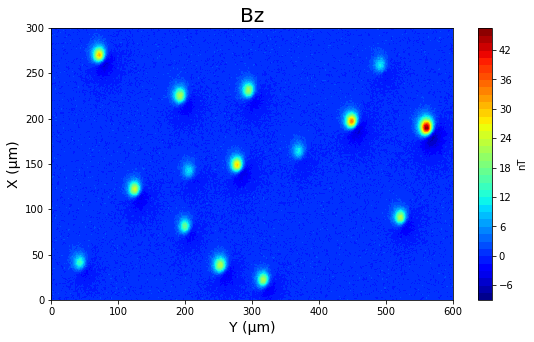

In [75]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

In [76]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculando derivadas por FFT

ddy, ky = y_derivative_fft(d_, Y_)
ddx, kx = x_derivative_fft(d_, X_)
ddz = z_derivative_fft(d, kx, ky)

# calculando derivadas (x e y) por FD
d_X, d_Y = (derivative_fd(d_, X_,Y_))


# a derivada em z por FD requer o filtro de continuação p/ cima

Text(0, 0.5, 'X (µm)')

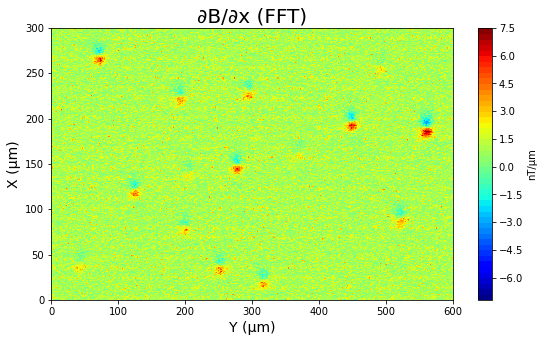

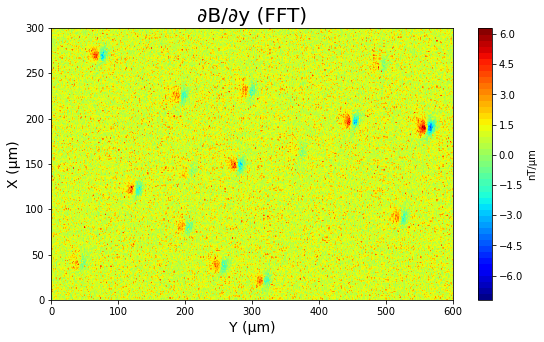

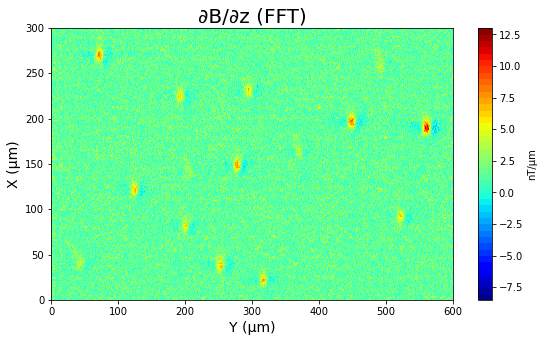

In [77]:
# plot das derivadas por FFT

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddx*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddy*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddz*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



Text(0, 0.5, 'X (µm)')

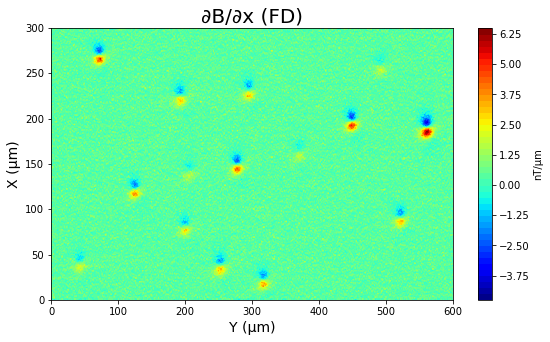

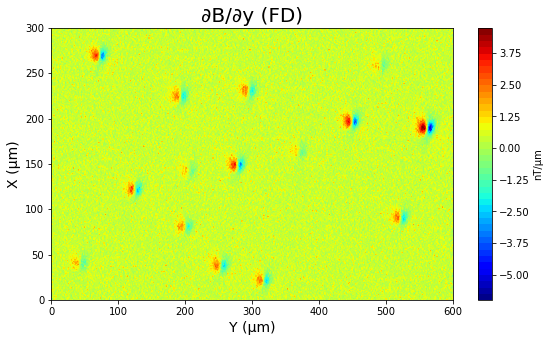

In [78]:
# plot das derivadas por FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_X*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_Y*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [79]:
# Calculo dos gradientes horizontais por FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)


Text(0, 0.5, 'X (µm)')

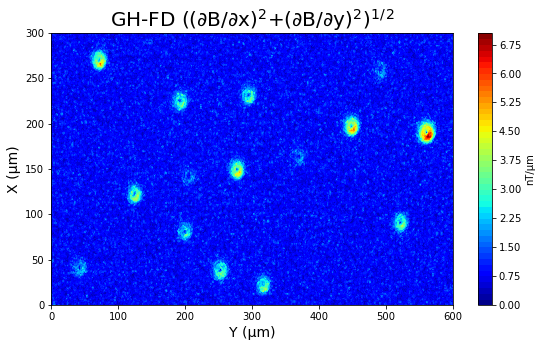

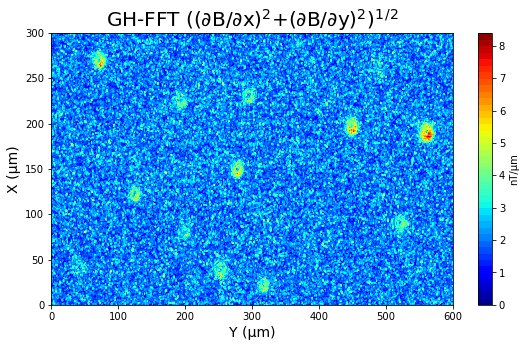

In [80]:
# Plot dos gradientes horizontais por FFT e FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [81]:
# Continuação p/ cima --> para remoção de ruído
altura = 1.0      # delta_z da cont p/ cima
delta_z = -altura*microm2m
upward = upward_continuation(d_, delta_z, kx, ky)

# Continuação p/ cima --> para posteriormente calcular a derivada em Z por FD
delta_z1 = -(altura-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, kx, ky)

delta_z2 = -(altura+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, kx, ky)

(300, 600)
(300, 600)
(300, 600)


Text(0, 0.5, 'X (µm)')

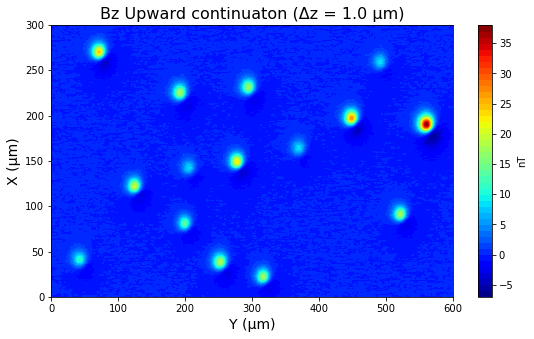

In [82]:
# Plot da Continuação p/ cima

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz Upward continuaton (Δz = %s µm)'%altura, fontsize=16)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [83]:
# New derivatives
ddy, ky = y_derivative_fft(upward, Y_)
ddx, kx = x_derivative_fft(upward, X_)

ddz = z_derivative_fft(upward, kx, ky)



Text(0, 0.5, 'X (µm)')

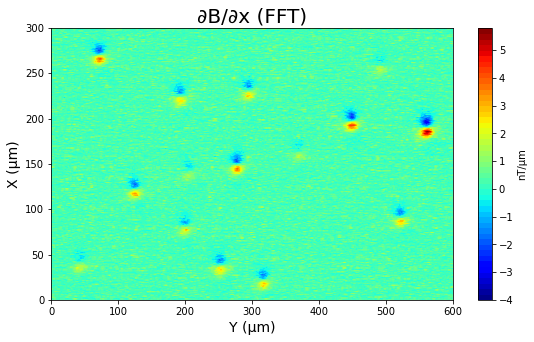

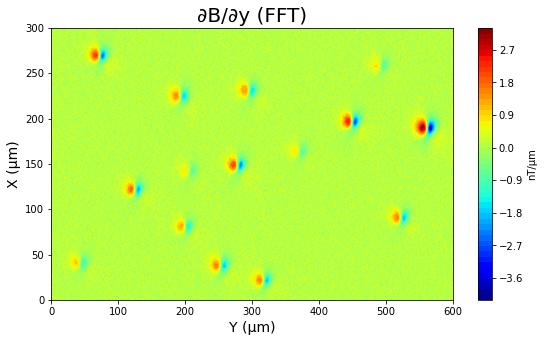

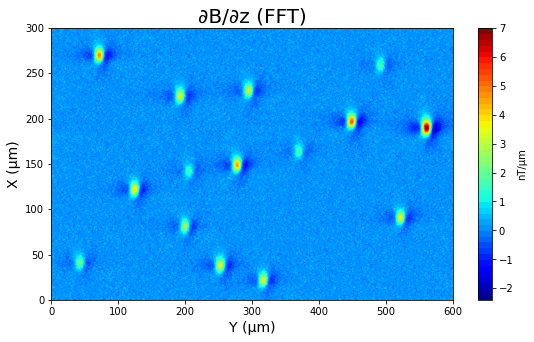

In [84]:
# Plot das Novas derivadas usando a continuação p/ cima por FFT

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddx)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddy)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddz)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [85]:

# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))


d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)



Text(0, 0.5, 'X (µm)')

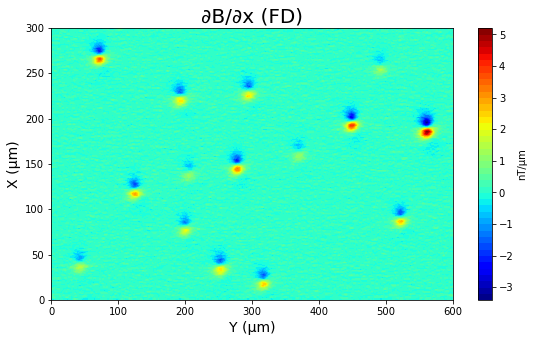

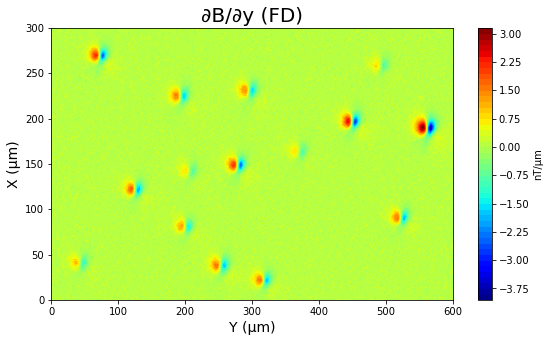

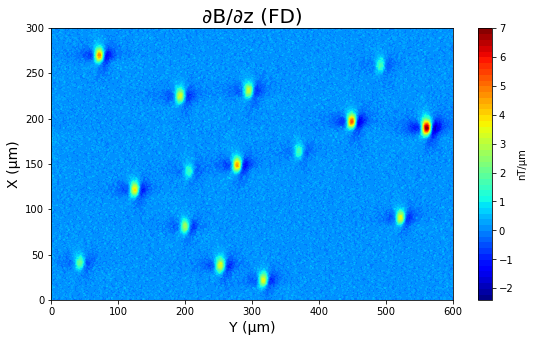

In [86]:
# Plot das novas derivadas (em x e y) usando a continuação p/ cima por FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (d_X)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (d_Y)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


d_Z_ = np.reshape(d_Z, (shape))

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_Z_*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



In [87]:
Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)


Text(0, 0.5, 'X (µm)')

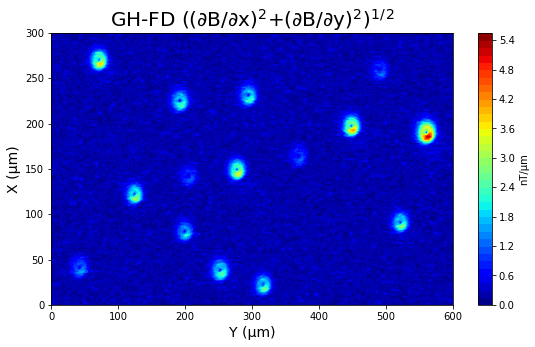

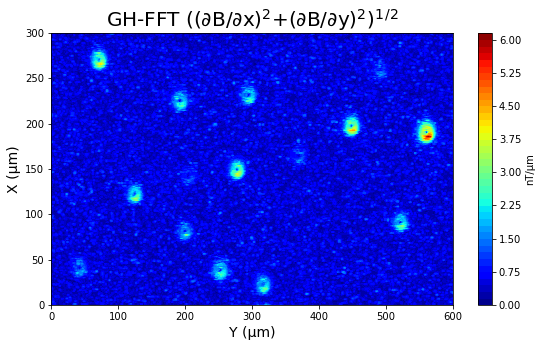

In [88]:
# Plot dos gradientes horizontais por FFT e FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

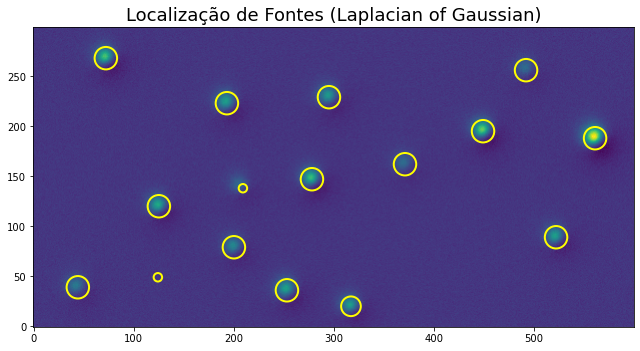

[1.87694020e-04 1.94793255e-04 2.67870625e-04 1.46784791e-04
 1.20006115e-04 8.84350267e-05 1.97007786e-05 3.60312493e-05
 2.22804475e-04 2.29576084e-04 7.89473478e-05 3.88505341e-05
 4.90719076e-05 2.56226231e-04 1.62121233e-04 1.36524710e-04]
[5.61743754e-04 4.49857828e-04 7.27859877e-05 2.78732592e-04
 1.25998759e-04 5.22812571e-04 3.17549357e-04 2.53672962e-04
 1.93826520e-04 2.96146664e-04 2.00844469e-04 4.40527935e-05
 1.23485586e-04 4.92521266e-04 3.70783970e-04 2.02316092e-04]
[ 8.05971397e-06  6.98652392e-06  7.00362804e-06  6.84051778e-06
  6.78970714e-06  6.70514812e-06  7.09473327e-06  7.72562892e-06
  7.81338856e-06  7.69389487e-06  6.45316119e-06  7.31129942e-06
 -4.14854234e-06  6.57854572e-06  6.86264973e-06  9.99613920e-06]


In [97]:
circles=sources_finder(Horiz_Grad_FFT, threshold=.05, data=d_)


Xc_FFT, Yc_FFT, Zc_FFT = euler_window(circles, X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index = 3.0, delta_z = delta_z)

print(Xc_FFT)
print(Yc_FFT)
print(Zc_FFT)

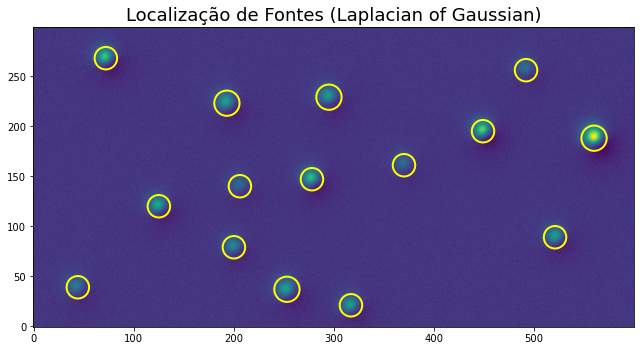

[188. 560.  19. 195. 449.  17. 268.  72.  17. 147. 278.  17. 120. 125.
  17.  89. 521.  17.  21. 317.  17.  37. 253.  19. 223. 193.  19. 229.
 295.  19.  79. 200.  17.  39.  44.  17. 256. 492.  17. 161. 370.  17.
 140. 206.  17.]
[1.87734328e-04 1.94762609e-04 2.67780333e-04 1.46729528e-04
 1.19776580e-04 8.86203918e-05 1.97350907e-05 3.60725710e-05
 2.22716021e-04 2.29042039e-04 7.89078147e-05 3.87551208e-05
 2.55935598e-04 1.61751478e-04 1.39554111e-04]
[5.61868217e-04 4.49837629e-04 7.28281807e-05 2.78743575e-04
 1.25944276e-04 5.22915441e-04 3.17608917e-04 2.53711576e-04
 1.93778299e-04 2.96099789e-04 2.00849143e-04 4.40464589e-05
 4.92436829e-04 3.70730066e-04 2.06667473e-04]
[7.99392140e-06 7.04713478e-06 7.07062929e-06 6.88873274e-06
 6.82124954e-06 6.72928800e-06 6.88215206e-06 7.51775345e-06
 7.54396045e-06 7.48752130e-06 6.46371303e-06 7.32290211e-06
 6.57652542e-06 6.82881084e-06 6.53627679e-06]


In [90]:
circles=sources_finder(Horiz_Grad_FD, threshold=.05, data=d_)
print(circles)
Xc_FD, Yc_FD, Zc_FD = euler_window(circles, X_, Y_, Z_, d_, d_X, d_Y, d_Z, structural_index = 3.0, delta_z = delta_z)

print(Xc_FD)
print(Yc_FD)
print(Zc_FD)

In [98]:
hx_FFT, hy_FFT, hz_FFT, M_FFT = least_square_solver(X, Y, Z, Xc_FFT, Yc_FFT, Zc_FFT, d)

print(hx_FFT)
print(hy_FFT)
print(hz_FFT)

[-3.76785311e-23 -2.16603231e-23 -1.94384353e-23 -1.75027001e-23
 -1.41756092e-23 -1.40244880e-23 -1.38998748e-23 -1.63109289e-23
 -1.65671077e-23 -1.28883626e-23 -9.53663682e-24 -9.56995666e-24
 -6.56912856e-28 -7.27507873e-24 -6.48774715e-24 -1.48967714e-23]
[ 2.37603268e-23  1.37227467e-23  1.19906298e-23  1.12109297e-23
  1.02256833e-23  8.84705130e-24  7.98878126e-24  1.08510673e-23
  1.08759324e-23  1.06486873e-23  6.16662023e-24  6.76693869e-24
 -4.52834543e-28  3.96099973e-24  4.30804116e-24 -4.92952219e-25]
[4.32767727e-23 2.44041894e-23 2.19631476e-23 2.04393694e-23
 1.74083083e-23 1.50201950e-23 1.63671044e-23 2.04587040e-23
 1.98579404e-23 1.91192151e-23 1.15064126e-23 1.11381240e-23
 3.42649129e-28 7.63199960e-24 8.63632459e-24 9.79251707e-24]


In [99]:
hx_FD, hy_FD, hz_FD, M_FD = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)

print(hx_FD)
print(hy_FD)
print(hz_FD)

[-3.70443268e-23 -2.20046778e-23 -1.99831201e-23 -1.78429133e-23
 -1.49265849e-23 -1.36169540e-23 -1.33235160e-23 -1.56393382e-23
 -1.60909070e-23 -1.40075320e-23 -9.42912195e-24 -9.75541262e-24
 -7.60974368e-24 -6.94651053e-24 -6.90512069e-24]
[2.43500954e-23 1.37752355e-23 1.22851007e-23 1.13997914e-23
 1.01683194e-23 9.15888147e-24 7.85039364e-24 1.05873484e-23
 1.02566560e-23 1.01750552e-23 6.15182399e-24 6.76867036e-24
 3.84350018e-24 4.21345382e-24 3.88754033e-24]
[4.27313453e-23 2.46165661e-23 2.20144723e-23 2.04947372e-23
 1.72618154e-23 1.52262038e-23 1.57872782e-23 1.98024405e-23
 1.89349791e-23 1.79823009e-23 1.14589443e-23 1.10893187e-23
 7.47419134e-24 8.40336146e-24 7.25574539e-24]


[ 147.76420242  147.64398224  148.3315732   147.35939308  144.19491785
  147.7550896   150.11239637  146.365623    146.71600456  140.4356313
  147.11231317  144.73578019 -145.42005506  151.43341276  146.41475434
 -178.10470482]
[44.172886   43.58379801 43.87982718 44.51919713 44.88404053 42.17101852
 45.59247181 46.24172527 45.05761054 48.83262653 45.37517853 43.54001071
 23.24138569 42.6559253  47.95740065 33.30486321]

108.30314463761091
42.813122850576235


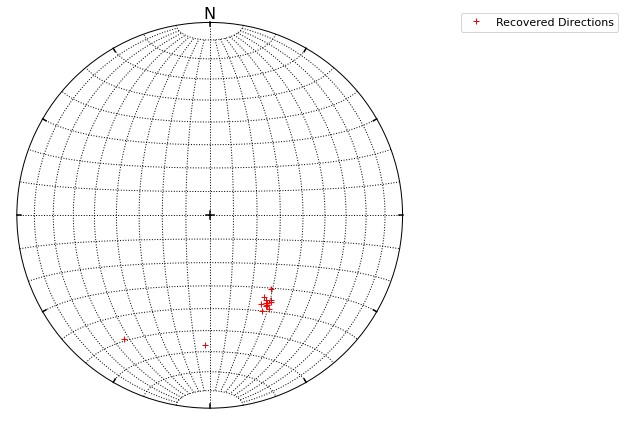

In [100]:
D_FFT, I_FFT = directions(hx_FFT, hy_FFT, hz_FFT, plot=True)

print(D_FFT)
print(I_FFT)

print()

print(np.mean(D_FFT))
print(np.mean(I_FFT))

[146.6821533  147.95285925 148.4178847  147.42559546 145.73644456
 146.07488058 149.49283977 145.90321442 147.48577383 144.00538824
 146.8784419  145.24563939 153.20274712 148.76080554 150.62075743]
[43.94759066 43.4775678  43.18250382 44.06650601 43.70398519 42.85606868
 45.59210711 46.35695798 44.77867784 46.0862329  45.50558989 43.04380549
 41.24128536 45.96667918 42.47842502]

147.59236169793576
44.15226552799355


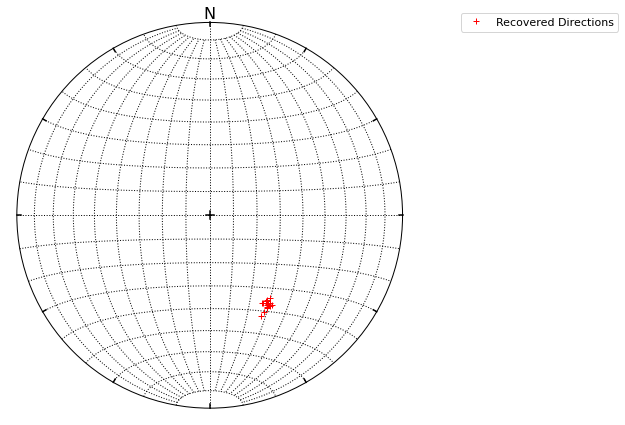

In [101]:
D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True)

print(D_FD)
print(I_FD)

print()

print(np.mean(D_FD))
print(np.mean(I_FD))

In [102]:
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * 0.0125
sigma_D_FFT, sigma_I_FFT = uncertainties(sigma_noise, M_FFT, hx_FFT, hy_FFT, hz_FFT)

print(sigma_D_FFT)
print(sigma_I_FFT)


[ 0.13775595  0.20151616  0.22695959  0.24258916  0.28600276  0.29715039
  0.32931864  0.29741525  0.29794118  0.34662331  0.41552737  0.46519209
 38.66598138  0.5820723   0.64984119  0.5427343 ]
[ 0.08514439  0.12536954  0.14079232  0.1493715   0.17537136  0.18756857
  0.2006352   0.17944641  0.18233251  0.20194781  0.25336445  0.2895874
 26.87907005  0.36567828  0.3832995   0.36598791]


In [103]:
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * 0.0125
sigma_D_FD, sigma_I_FD = uncertainties(sigma_noise, M_FD, hx_FD, hy_FD, hz_FD)

print(sigma_D_FD)
print(sigma_I_FD)

[0.13702798 0.20105536 0.22345292 0.24007656 0.2782576  0.30149104
 0.32943483 0.29850175 0.2965566  0.32392084 0.41983821 0.46006895
 0.56536334 0.61936433 0.60405278]
[0.08490615 0.12522473 0.13965279 0.14857571 0.1728888  0.18900494
 0.20066271 0.17984039 0.18207128 0.19579303 0.25557196 0.28789837
 0.36008576 0.37491674 0.38013287]
